In [1]:
import numpy as np
import skimage.feature
import matplotlib
import matplotlib.pyplot as plt
import math
import pandas
import scipy
from scipy import io
from scipy import stats
from datetime import datetime
from IPython.display import clear_output

In [2]:
def cov_to_pts( cov ):
    circ = np.linspace( 0, 2*np.pi, 100 )
    sf = np.asarray( [ np.cos( circ ), np.sin( circ ) ] )
    [u,s,v] = np.linalg.svd( cov )
    pmat = u*2.447*np.sqrt(s) # 95% confidence
    return np.dot(  pmat, sf )

In [3]:
data = io.loadmat('data/kfdata.mat')['data']
true_data = io.loadmat('data/kfdata.mat')['true_data']

In [4]:
# our dynamics are described by random accelerations
A = np.asarray([
    [ 1, 0, 1, 0, 0.5, 0 ],
    [ 0, 1, 0, 1, 0, 0.5 ],
    [ 0, 0, 1, 0, 1, 0 ],
    [ 0, 0, 0, 1, 0, 1 ],
    [ 0, 0, 0, 0, 1, 0 ],
    [ 0, 0, 0, 0, 0, 1 ] ])
 
# our observations are only the position components
C = np.asarray([
    [1, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0]])
 
# our dynamics noise tries to force random accelerations to account
# for most of the dynamics uncertainty
Q = 1e-2 * np.eye( 6 )
Q[4,4] = 0.5  # variance of accelerations is higher
Q[5,5] = 0.5
 
# our observation noise
R = 20 * np.eye( 2 )

In [5]:
# t = 0
# yhat = np.dot( C, np.dot( A, mu_t ) )
# sigp = np.dot( A, np.dot( sigma_t, A.T ) ) + Q
# S_t = np.dot( C, np.dot( sigp, C.T ) ) + R
# K_t = np.dot( sigp, np.dot( C.T, np.linalg.pinv(S_t) ) )
# mu_t = np.dot( A, mu_t ) + np.dot( K_t, (np.atleast_2d(data[t]).T - yhat))
# sigma_t = np.dot( (np.eye(6,6) - np.dot( K_t, C )), sigp )

In [6]:
def kalmanfilter(data):
    # initial state
    mu_t = np.zeros(( 6, 1 ))
    sigma_t = np.eye( 6 )
    mus = []
    sigs = []
    for t in range(data.shape[0]):
        yhat = np.dot( C, np.dot( A, mu_t ) )
        sigp = np.dot( A, np.dot( sigma_t, A.T ) ) + Q
        S_t = np.dot( C, np.dot( sigp, C.T ) ) + R
        K_t = np.dot( sigp, np.dot( C.T, np.linalg.pinv(S_t) ) )
        mu_t = np.dot( A, mu_t ) + np.dot( K_t, (np.atleast_2d(data[t]).T - yhat))
        mus.append(mu_t)
        sigma_t = np.dot( (np.eye(6,6) - np.dot( K_t, C )), sigp )
        sigs.append(sigma_t)

    mus = np.array(mus)
    mus = mus.reshape(data.shape[0], 6)
    sigs = np.array(sigs)
    return mus, sigs

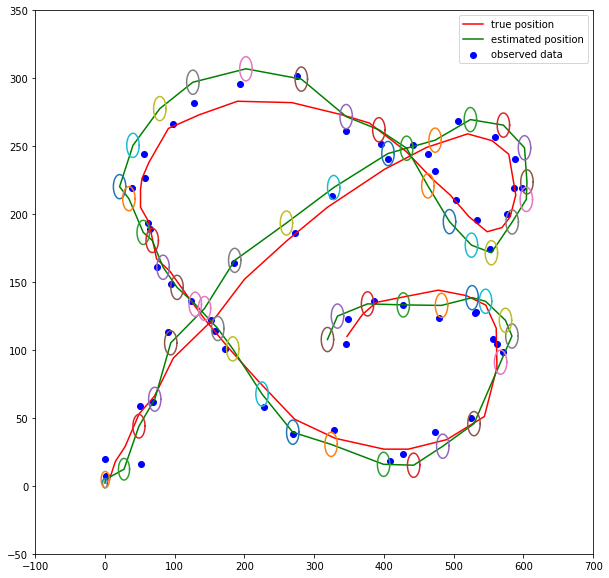

In [7]:
mus, sigs = kalmanfilter(data)

plt.figure(figsize=(10,10))

plt.scatter(data.T[0], data.T[1], label='observed data', c='Blue')
plt.plot(true_data.T[0], true_data.T[1], label='true position', c='Red')
plt.plot(mus.T[0], mus.T[1], label='estimated position', c='Green')
for t in range(data.shape[0]):
    foo = cov_to_pts( sigs[t][0:2,0:2] )
    plt.plot( foo[0,:] + mus[t][0], foo[1,:] + mus[t][1] )


plt.xlim(xmin=-100,xmax=700)
plt.ylim(ymin=-50,ymax=350)

plt.legend()
plt.show()

In [8]:
tmp = scipy.io.loadmat('data/ball_data.mat')
frames = tmp['frames']  # frames of our video
ball = tmp['ball']  # our little template

bdata = []
for i in range( 0, frames.shape[1] ):
    tmp = np.reshape( frames[:,i], (360,243) ).T  # slurp out a frame
    ncc = skimage.feature.match_template( tmp, ball )  # create a normalized cross correlation image
    maxloc = np.unravel_index( tmp.argmax(), tmp.shape )  # find the point of highest correlation
    bdata.append( maxloc )  # record the results

bdata = np.asarray( bdata )

In [9]:
def kalmanfilter2(data):
    # initial state
    mu_t = np.zeros(( 6, 1 ))
    tmp = np.power(data[0], 2)
    tmp = np.sqrt(tmp[0] + tmp[1])
    mu_t[0] += tmp
    mu_t[1] += tmp
    sigma_t = np.eye( 6 )
    mus = []
    sigs = []
    for t in range(data.shape[0]):
        yhat = np.dot( C, np.dot( A, mu_t ) )
        sigp = np.dot( A, np.dot( sigma_t, A.T ) ) + Q
        S_t = np.dot( C, np.dot( sigp, C.T ) ) + R
        K_t = np.dot( sigp, np.dot( C.T, np.linalg.pinv(S_t) ) )
        mu_t = np.dot( A, mu_t ) + np.dot( K_t, (np.atleast_2d(data[t]).T - yhat))
        mus.append(mu_t)
        sigma_t = np.dot( (np.eye(6,6) - np.dot( K_t, C )), sigp )
        sigs.append(sigma_t)

    mus = np.array(mus)
    mus = mus.reshape(data.shape[0], 6)
    sigs = np.array(sigs)
    return mus, sigs

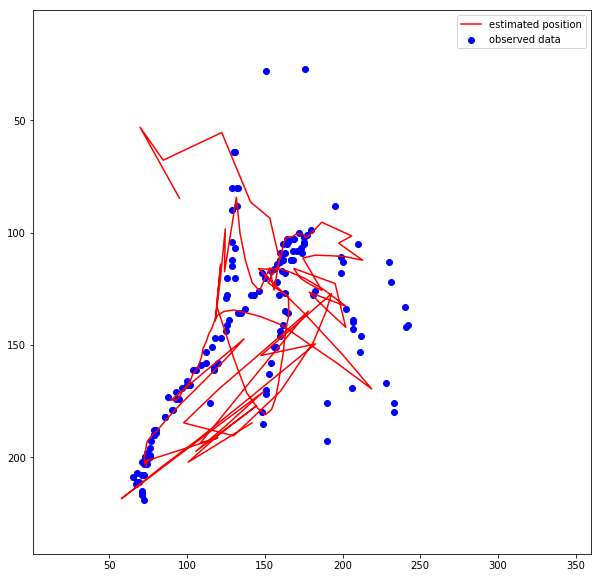

In [10]:
Q = 1e-3 * np.eye( 6 )
Q[4,4] = 1e-1  # variance of accelerations is higher
Q[5,5] = 1e-1
# our observation noise
A = np.asarray([
    [ 0.5, 0, 1, 0, 0.5, 0 ],
    [ 0, 0.5, 0, 1, 0, 0.5 ],
    [ 0, 0, 1, 0, 1, 0 ],
    [ 0, 0, 0, 1, 0, 1 ],
    [ 0, 0, 0, 0, 1, 0 ],
    [ 0, 0, 0, 0, 0, 1 ] ])
R = 20 * np.eye( 2 )
"""The parameters I changed were based on lowering the amount that the estimation moves, 
so it won't be pulled so hard by the observed data.  In order to do so I experimented 
with all of the parameters, including the C matrix.  Changing the C matrix seemed only
to move the estimation to the right or left, up or down, of the observed data, which didn't help.  
It seems like lowering the R and Q variance matrice values seemed to help the most, so 
that I what I did (I was increasing the variance with the assumption that it would give 
less credence to the observed data, but that didn't seem to work).  I also decreased the values
in the A matrix that corresponded to the x and y positions hoping that the observed dat wouldn't 
have as much of an impact if I did so.  That seemed to work okay but it didn't have a huge effect."""

mus, sigs = kalmanfilter2(bdata)

plt.figure(figsize=(10,10))

plt.scatter(bdata.T[0], bdata.T[1], label='observed data', c='Blue')
plt.plot(mus.T[0], mus.T[1], label='estimated position', c='Red')

plt.xlim([1, 360])
plt.ylim([243,1])

plt.legend()
plt.show()

In [11]:
def show_shot(t):
    tmp = np.reshape( frames[:,t], (360,243) ).T

    plt.figure(1)
    plt.clf()
    plt.imshow( tmp, interpolation='nearest', cmap=matplotlib.cm.gray )
    plt.scatter( bdata[t][1], bdata[t][0] )
    plt.scatter( mus[t][1], mus[t][0] )

    foo = cov_to_pts( sigs[t][0:2,0:2] )

    plt.plot( foo[0,:] + mus[t][1], foo[1,:] + mus[t][0] )
    plt.xlim([1, 360])
    plt.ylim([243,1])
    clear_output(wait = True)

    plt.pause(0.01)

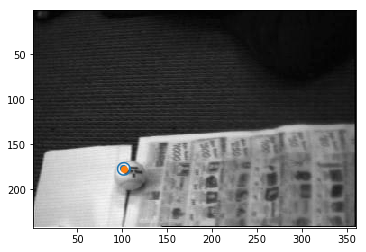

In [12]:
t = 54
show_shot(t)

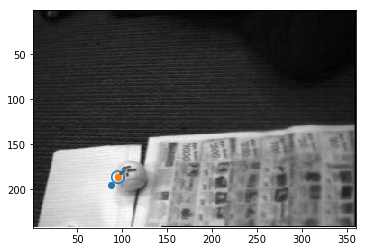

In [13]:
t = 56
show_shot(t)

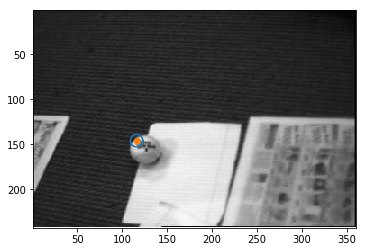

In [14]:
t = 78
show_shot(t)

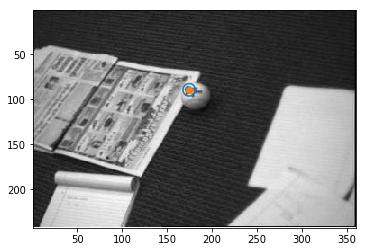

In [15]:
t = 106
show_shot(t)

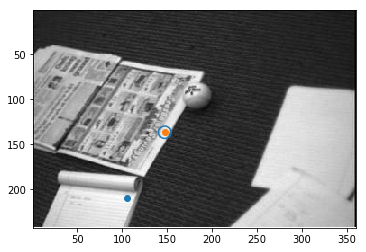

In [16]:
t = 107
show_shot(t)

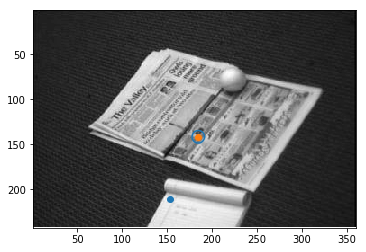

In [17]:
# Full video!!!
for t in range(0, bdata.shape[0]):
    show_shot(t)